
![Acropolis-Partheon](https://drive.google.com/uc?export=view&id=1G8hJ0KK5i0wNaDZYoiTSJskxaIe2Lt-B)

In this notebook we use a module that packages the DELF neural network for processng images and identifying keypoints and descriptors 

**What is DELF??**

DEep Local Feature module can be used for image retrievals. Each noteworthy point in the image is described using a 40-dimensional vector (*known as a feature vector*)


The model in TF-Hub is trained on GLDv1 


[Link to the T-Hub Colab notebook](https://www.tensorflow.org/hub/tutorials/tf_hub_delf_module)

In [1]:
# Importing basic libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
# Importing libraries required for the matching operation

from absl import logging

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO

import tensorflow as tf

import tensorflow_hub as hub
from six.moves.urllib.request import urlopen

Replace the value of `images` with any of the other possible options in the next code block

In [3]:

images = "Acropolis" 
if images == "Bridge of Sighs":
  # from: https://commons.wikimedia.org/wiki/File:Bridge_of_Sighs,_Oxford.jpg
  # by: N.H. Fischer
  IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/2/28/Bridge_of_Sighs%2C_Oxford.jpg'
  # from https://commons.wikimedia.org/wiki/File:The_Bridge_of_Sighs_and_Sheldonian_Theatre,_Oxford.jpg
  # by: Matthew Hoser
  IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/c/c3/The_Bridge_of_Sighs_and_Sheldonian_Theatre%2C_Oxford.jpg'
elif images == "Golden Gate":
  IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/1/1e/Golden_gate2.jpg'
  IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/3/3e/GoldenGateBridge.jpg'
elif images == "Acropolis":
  IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/c/ce/2006_01_21_Ath%C3%A8nes_Parth%C3%A9non.JPG'
  IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/5/5c/ACROPOLIS_1969_-_panoramio_-_jean_melis.jpg'
else:
  IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/d/d8/Eiffel_Tower%2C_November_15%2C_2011.jpg'
  IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/a/a8/Eiffel_Tower_from_immediately_beside_it%2C_Paris_May_2008.jpg'

The following function downloads the image dfrom the given link `url` and resizes (*standardizes*) it to a square of 256x256

In [4]:
def download_and_resize(name, url, new_width=256, new_height=256):
  path = tf.keras.utils.get_file(url.split('/')[-1], url)
  image = Image.open(path)
  image = ImageOps.fit(image, (new_width, new_height), Image.ANTIALIAS)
  return image

Lets download the image of Acropolis-Paratheon and then plot it using `matplotlib`

2637824/2637626 [==============================] - 0s 0us/step


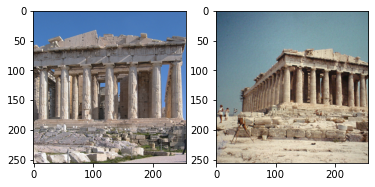

In [5]:
image1 = download_and_resize('image_1.jpg', IMAGE_1_URL)
image2 = download_and_resize('image_2.jpg', IMAGE_2_URL)

plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)

**Load the DELF neural model from TensorFlow-Hub**

Next create a function to return the features

In [6]:
delf = hub.load('https://tfhub.dev/google/delf/1').signatures['default']

In [7]:
def run_delf(image):
  np_image = np.array(image)
  float_image = tf.image.convert_image_dtype(np_image, tf.float32)

  return delf(
      image=float_image,
      score_threshold=tf.constant(100.0),
      image_scales=tf.constant([0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0]),
      max_feature_num=tf.constant(1000))

Calculate the DELF features of both the images

In [8]:
result1 = run_delf(image1)
result2 = run_delf(image2)

Here's the **meat** of the operation where the extracted features are mapped

In [9]:

def match_images(image1, image2, result1, result2 ):
  distance_threshold = 0.8

  # Read features.
  num_features_1 = result1['locations'].shape[0]
  print("Loaded image 1's %d features" % num_features_1)
  
  num_features_2 = result2['locations'].shape[0]
  print("Loaded image 2's %d features" % num_features_2)

  # Find nearest-neighbor matches using a KD tree.
  d1_tree = cKDTree(result1['descriptors'])
  _, indices = d1_tree.query(
      result2['descriptors'],
      distance_upper_bound=distance_threshold)

  # Select feature locations for putative matches.
  locations_2_to_use = np.array([
      result2['locations'][i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  locations_1_to_use = np.array([
      result1['locations'][indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])

  # Perform geometric verification using RANSAC.
  _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)

  print('Found %d inliers' % sum(inliers))

  # Visualize correspondences.
  _, ax = plt.subplots()
  inlier_idxs = np.nonzero(inliers)[0]
  plot_matches(
      ax,
      image1,
      image2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='b')
  ax.axis('off')
  ax.set_title('DELF correspondences')

  return inliers


Loaded image 1's 273 features
Loaded image 2's 165 features
Found 43 inliers


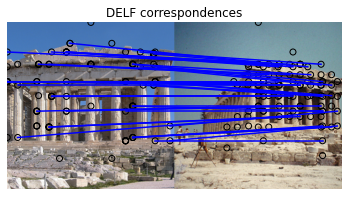

In [10]:
match_inliers = match_images(image1, image2, result1, result2)

In [11]:
sum(match_inliers)/len(match_inliers)

0.4387755102040816

* We can now create a pipeline where each candidate image in the index is run against the test image 
* Once the scoring is done, then the best candidate with the highest number of matched inliers can be selected

Let's check what we can do with another example from the Oxford Buildings dataset

We will take some sample `IMAGES` and then calculat the inliers for a few pairs and then check which one provides the best match

In [12]:
IMAGES = ['all_souls_000002.jpg', 'all_souls_000005.jpg', 'all_souls_000001.jpg', 'bodleian_000396.jpg', 
          'bodleian_000395.jpg', 'christ_church_000061.jpg', 'christ_church_000081.jpg']

In [13]:
import tarfile

def download_and_resize_local(fname, zipfile, new_width=256, new_height=256):
    zipFile = tarfile.open(zipfile)
    zipFile.extract(fname, '.')
    image = Image.open(fname)
    image = ImageOps.fit(image, (new_width, new_height), Image.ANTIALIAS)
    return image

In [14]:

def match_images_2(image1, image2, result1, result2, fnamelist ):
  distance_threshold = 0.8

  # Read features.
  num_features_1 = result1['locations'].shape[0]
  #print("Loaded image 1's %d features" % num_features_1)
  
  num_features_2 = result2['locations'].shape[0]
  #print("Loaded image 2's %d features" % num_features_2)

  # Find nearest-neighbor matches using a KD tree.
  d1_tree = cKDTree(result1['descriptors'])
  _, indices = d1_tree.query(
      result2['descriptors'],
      distance_upper_bound=distance_threshold)

  # Select feature locations for putative matches.
  locations_2_to_use = np.array([
      result2['locations'][i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  locations_1_to_use = np.array([
      result1['locations'][indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])

  # Perform geometric verification using RANSAC.
  _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)

  #print('Found %d inliers' % sum(inliers))

  # Visualize correspondences.
  _, ax = plt.subplots()
  inlier_idxs = np.nonzero(inliers)[0]
  plot_matches(
      ax,
      image1,
      image2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='b')
  ax.axis('off')
  ax.set_title(fnamelist[0] + " ||| " + fnamelist[1])

  return inliers


  0%|          | 0/6 [00:00<?, ?it/s]

Retrieving for sample image:  all_souls_000002.jpg


100%|██████████| 6/6 [01:03<00:00, 10.52s/it]


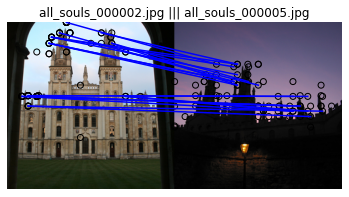

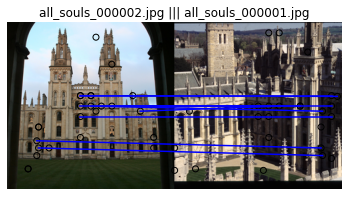

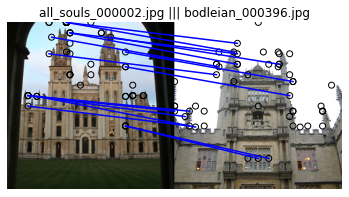

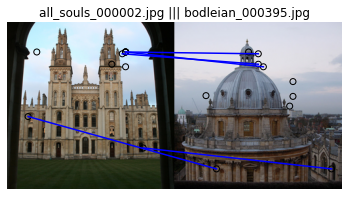

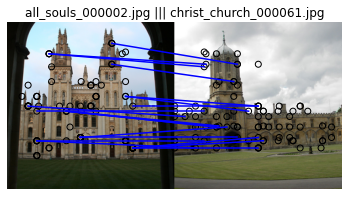

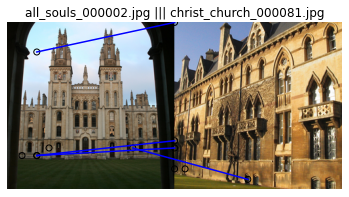

In [15]:
from tqdm import tqdm

zippath = '/kaggle/input/oxbuildings/oxbuild_images.tgz'
image1 = download_and_resize_local(IMAGES[0], zippath )
print("Retrieving for sample image: ", IMAGES[0])

inlier_list = list()

for idx in tqdm(range(1,len(IMAGES))):
    #print("Matching with image: ", IMAGES[idx])
    image2 = download_and_resize_local(IMAGES[idx], zippath)
    result1 = run_delf(image1)
    result2 = run_delf(image2)

    match_inliers = match_images_2(image1, image2, result1, result2, [IMAGES[0], IMAGES[idx]])
    inlier_list.append({'image': IMAGES[idx], 'inlier': sum(match_inliers)})

In [16]:
inlierdf = pd.DataFrame(inlier_list).sort_values(by='inlier', ascending=False)
inlierdf

,image,inlier
0,all_souls_000005.jpg,22
4,christ_church_000061.jpg,19
2,bodleian_000396.jpg,16
1,all_souls_000001.jpg,10
3,bodleian_000395.jpg,5
5,christ_church_000081.jpg,4


The good stuff first! 

1. The system matched with a night pic of the same church 


some drawbacks - 

1. The neural network got confused with the towers(christ church & all souls)